In [37]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# gensim
!pip install gensim
from gensim.models import Word2Vec, FastText
import gensim.downloader as api

# tensorflow / keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [38]:
# Reproducibility
# untuk mengatur seed (nilai acak awal) supaya hasil percobaan selalu sama (reproducible) setiap kali dijalankan
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Menggunakan data yang sudah di preprocessing pada CPMK 2 & hanya menggunakan 250 data yang sudah di lakukan labeling manual

In [39]:
# Config / Hyperparameters
DATA_PATH = "/content/drive/MyDrive/klasifikasi data/data_250_manual_labeled.csv"
OUT_DIR = "/content/klasifikasi_output_full_pipeline"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = SEED
MAX_SEQ_LEN = 100
MAX_NUM_WORDS = 20000
EMBED_SIZE = 100
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

# LSTM tuning grid (simple small grid to save time)
LSTM_GRID_UNITS = [64, 128]
LSTM_GRID_EPOCHS = [4, 6]
FREEZE_EMBEDDING = True
PATIENCE = 3

In [40]:
# LOAD DATASET
df = pd.read_csv(DATA_PATH, sep=None, engine='python')
if 'cleaned_text' not in df.columns or 'manual_label' not in df.columns:
    raise ValueError("Dataset harus memiliki kolom 'cleaned_text' dan 'manual_label'.")

df = df.dropna(subset=['cleaned_text', 'manual_label']).reset_index(drop=True)
df['cleaned_text'] = df['cleaned_text'].astype(str)
df['manual_label'] = df['manual_label'].astype(str)

print(f"Loaded {len(df)} rows. Labels: {df['manual_label'].unique()}")

Loaded 250 rows. Labels: ['negatif' 'positif' 'netral']


In [41]:
# Prepare X, y (encode labels to ints)
X = df['cleaned_text']
y_raw = df['manual_label']

le = LabelEncoder()
y = le.fit_transform(y_raw)
label_names = le.classes_
num_classes = len(label_names)
print("Label mapping:", {i: lab for i, lab in enumerate(label_names)})

Label mapping: {0: 'negatif', 1: 'netral', 2: 'positif'}


In [42]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# tokens for embedding training
X_train_tokens = X_train.apply(lambda s: s.split())
X_test_tokens = X_test.apply(lambda s: s.split())

In [43]:
# Helper functions
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return acc, prec, rec, f1

def plot_cm(y_true, y_pred, title, labels=label_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,4))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# storage
results = []
sklearn_models_to_save = {}  # name -> (model, processor/vectorizer)


Klasifikasi Machine Learning Klasik dengan Bag of Words sebagai ekstraksi fitur dan Multinomial Naive Bayes


[1] BoW + MultinomialNB


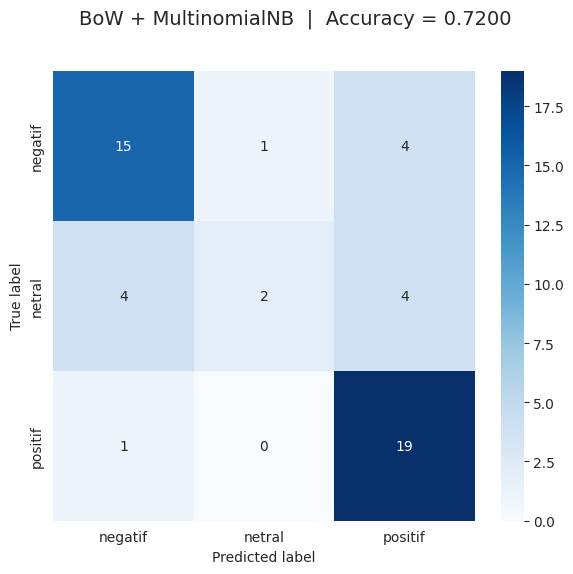

In [62]:
# Classic ML: BoW + NB
print("\n[1] BoW + MultinomialNB")
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

model_nb = MultinomialNB()
model_nb.fit(X_train_cv, y_train)
pred_nb = model_nb.predict(X_test_cv)
results.append(["BoW + MultinomialNB"] + list(compute_metrics(y_test, pred_nb)))
plot_cm(y_test, pred_nb, "BoW + MultinomialNB")
sklearn_models_to_save["BoW_MultinomialNB"] = (model_nb, cv)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Klasifikasi Machine Learning Klasik dengan TF-IDF dan Linear Support Vector Machine (SVM)


[2] TF-IDF + LinearSVC


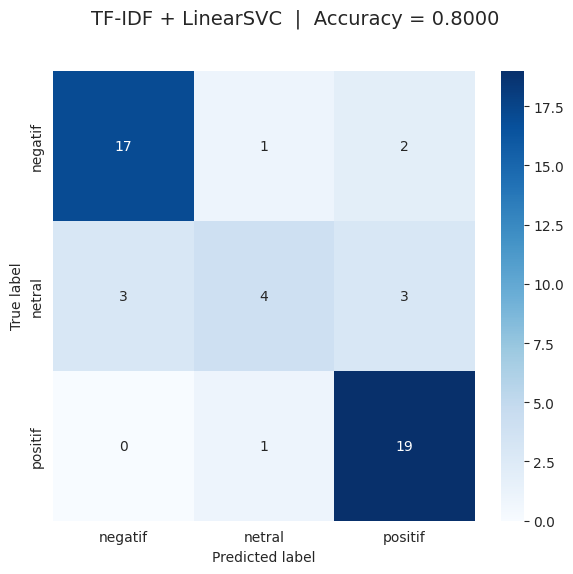

In [45]:
# TF-IDF + SVM
print("\n[2] TF-IDF + LinearSVC")
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model_svm = LinearSVC(random_state=RANDOM_STATE)
model_svm.fit(X_train_tfidf, y_train)
pred_svm = model_svm.predict(X_test_tfidf)
results.append(["TF-IDF + LinearSVC"] + list(compute_metrics(y_test, pred_svm)))
plot_cm(y_test, pred_svm, "TF-IDF + LinearSVC")
sklearn_models_to_save["TFIDF_LinearSVC"] = (model_svm, tfidf)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Klasifikasi Machine Learning Klasik dengan TF-IDF sebagai ekstraksi fitur dan Logistic Regression


[3] TF-IDF + LogisticRegression


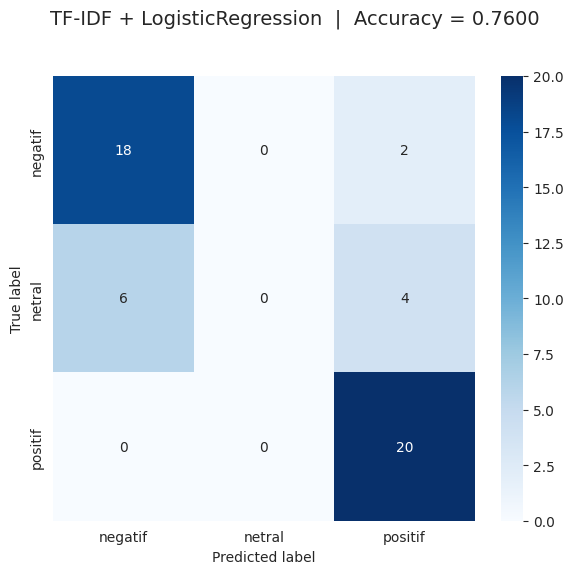

In [46]:
# TF-IDF + LogisticRegression
print("\n[3] TF-IDF + LogisticRegression")
model_lr = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
model_lr.fit(X_train_tfidf, y_train)
pred_lr = model_lr.predict(X_test_tfidf)
results.append(["TF-IDF + LogisticRegression"] + list(compute_metrics(y_test, pred_lr)))
plot_cm(y_test, pred_lr, "TF-IDF + LogisticRegression")
sklearn_models_to_save["TFIDF_LogisticRegression"] = (model_lr, tfidf)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Klasifikasi Machine Learning Klasik dengan TF-IDF sebagai ekstraksi fitur dan Random Forest Classifier


[4] TF-IDF + RandomForest


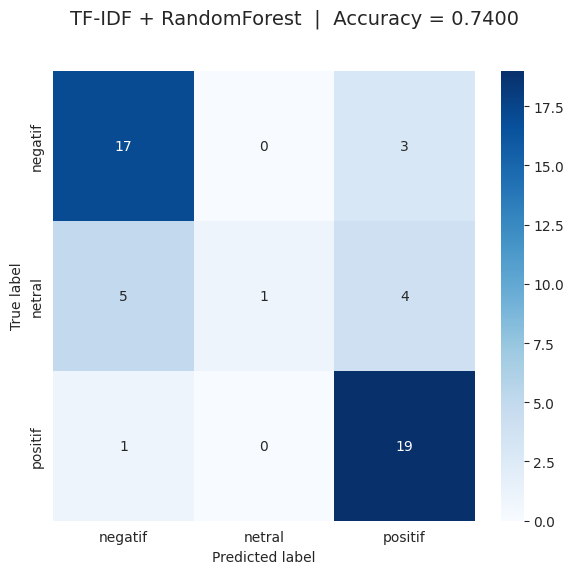

In [47]:
# TF-IDF + RandomForest
print("\n[4] TF-IDF + RandomForest")
model_rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
model_rf.fit(X_train_tfidf, y_train)
pred_rf = model_rf.predict(X_test_tfidf)
results.append(["TF-IDF + RandomForest"] + list(compute_metrics(y_test, pred_rf)))
plot_cm(y_test, pred_rf, "TF-IDF + RandomForest")
sklearn_models_to_save["TFIDF_RandomForest"] = (model_rf, tfidf)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Klasifikasi Machine Learning Klasik dengan Word2Vec sebagai ekstraksi fitur (dilatih dari data) Menggunakan rata-rata embedding dan Random Forest Classifier sebagai algoritma klasifikasi


[5] Word2Vec(avg) + RandomForest


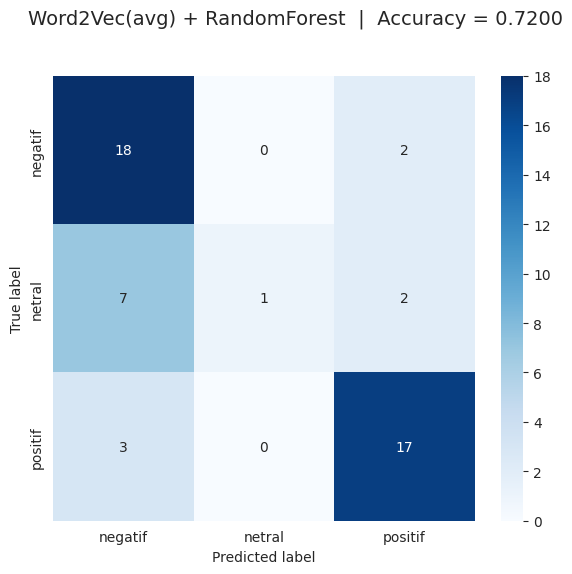

In [48]:
# Word2Vec (train) + RandomForest (avg embeddings)
print("\n[5] Word2Vec(avg) + RandomForest")
w2v_size = EMBED_SIZE
w2v_model = Word2Vec(sentences=list(X_train_tokens), vector_size=w2v_size, window=5, min_count=1, workers=4, seed=RANDOM_STATE)

def avg_emb_from_gensim(tokens_list, model, vector_size):
    vecs = []
    for tokens in tokens_list:
        v = [model.wv[w] for w in tokens if w in model.wv]
        if len(v) > 0:
            vecs.append(np.mean(v, axis=0))
        else:
            vecs.append(np.zeros(vector_size))
    return np.vstack(vecs)

X_train_w2v = avg_emb_from_gensim(X_train_tokens, w2v_model, w2v_size)
X_test_w2v = avg_emb_from_gensim(X_test_tokens, w2v_model, w2v_size)

model_w2v_rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
model_w2v_rf.fit(X_train_w2v, y_train)
pred_w2v_rf = model_w2v_rf.predict(X_test_w2v)
results.append(["Word2Vec(avg) + RandomForest"] + list(compute_metrics(y_test, pred_w2v_rf)))
plot_cm(y_test, pred_w2v_rf, "Word2Vec(avg) + RandomForest")
sklearn_models_to_save["Word2Vec_RF"] = (model_w2v_rf, w2v_model)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Klasifikasi Machine Learning Klasik dengan FastText sebagai ekstraksi fitur (dilatih dari data) Menggunakan rata-rata embedding dan Random Forest Classifier sebagai algoritma klasifikasi


[6] FastText(avg) + RandomForest


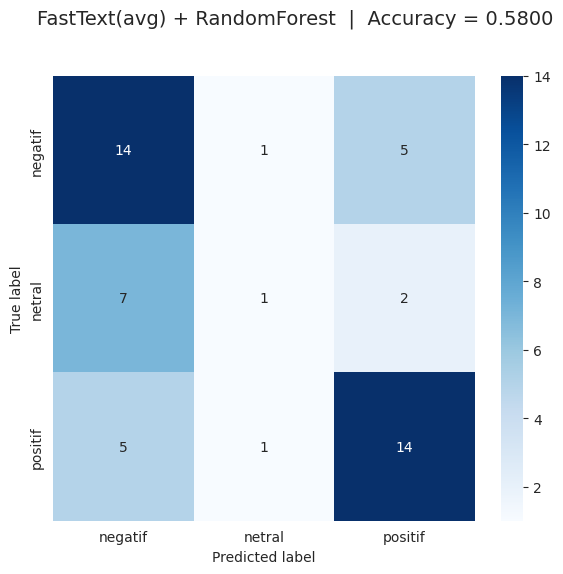

In [49]:
# FastText (train) + RandomForest
print("\n[6] FastText(avg) + RandomForest")
ft_size = EMBED_SIZE
ft_model = FastText(vector_size=ft_size, window=5, min_count=1, workers=4, seed=RANDOM_STATE)
ft_model.build_vocab(corpus_iterable=list(X_train_tokens))
ft_model.train(corpus_iterable=list(X_train_tokens), total_examples=len(X_train_tokens), epochs=10)

X_train_ft = avg_emb_from_gensim(X_train_tokens, ft_model, ft_size)
X_test_ft = avg_emb_from_gensim(X_test_tokens, ft_model, ft_size)

model_ft_rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
model_ft_rf.fit(X_train_ft, y_train)
pred_ft_rf = model_ft_rf.predict(X_test_ft)
results.append(["FastText(avg) + RandomForest"] + list(compute_metrics(y_test, pred_ft_rf)))
plot_cm(y_test, pred_ft_rf, "FastText(avg) + RandomForest")
sklearn_models_to_save["FastText_RF"] = (model_ft_rf, ft_model)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Klasifikasi Machine Learning Klasik dengan Ekstraksi Fitur GloVe (Pretrained Embeddings) Menggunakan Rata-Rata Vektor dan Random Forest Classifier


[7] Attempting to load GloVe via gensim.downloader (internet required)
GloVe loaded successfully.
[7a] GloVe(avg) + RandomForest


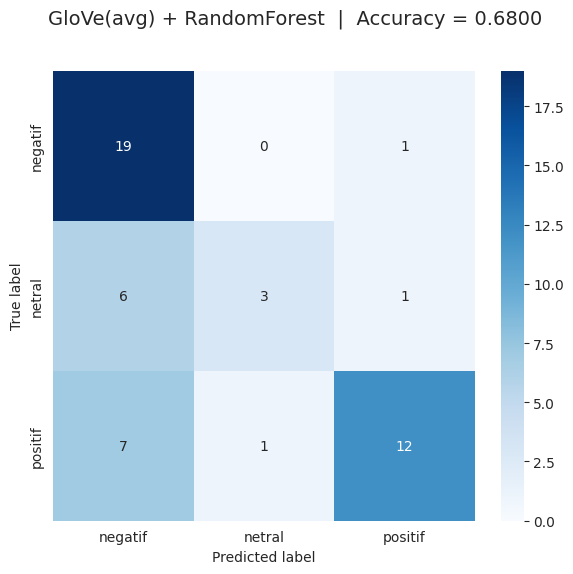

In [50]:
# GloVe (gensim.downloader) + RandomForest (avg) - needs internet
print("\n[7] Attempting to load GloVe via gensim.downloader (internet required)")
glove_size = EMBED_SIZE
glove_loaded = False
glove_model = None
try:
    glove_model = api.load(f"glove-wiki-gigaword-{glove_size}")
    glove_loaded = True
    print("GloVe loaded successfully.")
except Exception as e:
    print("GloVe download failed or no internet. Skipping GloVe experiments.")
    glove_loaded = False

if glove_loaded:
    print("[7a] GloVe(avg) + RandomForest")
    def avg_emb_glove(tokens_list, gmodel, vector_size):
        vecs = []
        for tokens in tokens_list:
            v = [gmodel[w] for w in tokens if w in gmodel]
            if len(v) > 0:
                vecs.append(np.mean(v, axis=0))
            else:
                vecs.append(np.zeros(vector_size))
        return np.vstack(vecs)

    X_train_glove = avg_emb_glove(X_train_tokens, glove_model, glove_size)
    X_test_glove = avg_emb_glove(X_test_tokens, glove_model, glove_size)

    model_glove_rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    model_glove_rf.fit(X_train_glove, y_train)
    pred_glove_rf = model_glove_rf.predict(X_test_glove)
    results.append(["GloVe(avg) + RandomForest"] + list(compute_metrics(y_test, pred_glove_rf)))
    plot_cm(y_test, pred_glove_rf, "GloVe(avg) + RandomForest")
    sklearn_models_to_save["GloVe_RF"] = (model_glove_rf, glove_model)

    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)

        plt.figure(figsize=(6, 6))

        plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)

        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

Mempersiapkan input Deep Learning berbasis embedding gabungan FastText + Word2Vec + GloVe.

In [51]:
# Prepare tokenizer + padded sequences for DL
print("\n[8] Prepare tokenizer & padded sequences (MAX_SEQ_LEN = {})".format(MAX_SEQ_LEN))
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
print("Num words in tokenizer:", len(word_index), " -> using num_words:", num_words)

# Build embedding_index prefer FT -> W2V -> GloVe
embedding_index = {}
# FastText
for w in ft_model.wv.index_to_key:
    embedding_index[w] = ft_model.wv[w]
# Word2Vec
for w in w2v_model.wv.index_to_key:
    if w not in embedding_index:
        embedding_index[w] = w2v_model.wv[w]
# GloVe
if glove_loaded:
    for w in glove_model.key_to_index:
        if w not in embedding_index:
            embedding_index[w] = glove_model[w]

# Build embedding matrix
embedding_matrix = np.zeros((num_words, EMBED_SIZE))
for word, i in word_index.items():
    if i >= num_words:
        continue
    vec = embedding_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBED_SIZE,))


[8] Prepare tokenizer & padded sequences (MAX_SEQ_LEN = 100)
Num words in tokenizer: 964  -> using num_words: 965


Arsitektur Model LSTM dan BiLSTM untuk Klasifikasi Teks Berbasis Embedding

In [52]:
# LSTM builder (trainable flag)
def build_lstm_model(num_words, embed_size, embedding_matrix, max_seq_len, num_classes, lstm_units=128, bidirectional=False, trainable_embedding=False):
    model = Sequential()
    model.add(Embedding(input_dim=num_words,
                        output_dim=embed_size,
                        input_length=max_seq_len,
                        weights=[embedding_matrix],
                        trainable=trainable_embedding))
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    else:
        model.add(LSTM(lstm_units))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    else:
        model.add(Dense(num_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']

    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

y_train_keras = np.array(y_train)
y_test_keras = np.array(y_test)


Klasifikasi Teks Menggunakan LSTM dengan Pretrained Embedding Hybrid


[9] Simple grid-search for LSTM hyperparams (small grid)

Training candidate LSTM: units=64, epochs=4, trainable_embedding=False
Epoch 1/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4166 - loss: 1.0964

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.4158 - loss: 1.0961 - val_accuracy: 0.2500 - val_loss: 1.0987
Epoch 2/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.4307 - loss: 1.0860 - val_accuracy: 0.2500 - val_loss: 1.1014
Epoch 3/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4317 - loss: 1.0669 - val_accuracy: 0.2500 - val_loss: 1.1288
Epoch 4/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4043 - loss: 1.0519 - val_accuracy: 0.2500 - val_loss: 1.1359
Candidate finished. Best val_loss=1.0987
 --> New best LSTM candidate saved: /content/klasifikasi_output_full_pipeline/lstm_units64_ep4.h5

Training candidate LSTM: units=64, epochs=6, trainable_embedding=False
Epoch 1/6
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3534 - loss: 1.0973

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.3683 - loss: 1.0969 - val_accuracy: 0.2500 - val_loss: 1.0974
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4165 - loss: 1.0878 - val_accuracy: 0.2500 - val_loss: 1.0989
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4554 - loss: 1.0714 - val_accuracy: 0.2500 - val_loss: 1.1093
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4290 - loss: 1.0630 - val_accuracy: 0.2500 - val_loss: 1.1661
Candidate finished. Best val_loss=1.0974
 --> New best LSTM candidate saved: /content/klasifikasi_output_full_pipeline/lstm_units64_ep6.h5

Training candidate LSTM: units=128, epochs=4, trainable_embedding=False
Epoch 1/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3007 - loss: 1.0966

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.3085 - loss: 1.0964 - val_accuracy: 0.4500 - val_loss: 1.0945
Epoch 2/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3990 - loss: 1.0855

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.3976 - loss: 1.0852 - val_accuracy: 0.4500 - val_loss: 1.0940
Epoch 3/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4051 - loss: 1.0626 - val_accuracy: 0.4500 - val_loss: 1.1139
Epoch 4/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.3914 - loss: 1.0622 - val_accuracy: 0.2500 - val_loss: 1.0995
Candidate finished. Best val_loss=1.0940
 --> New best LSTM candidate saved: /content/klasifikasi_output_full_pipeline/lstm_units128_ep4.h5

Training candidate LSTM: units=128, epochs=6, trainable_embedding=False
Epoch 1/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4120 - loss: 1.0967

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.4095 - loss: 1.0965 - val_accuracy: 0.2500 - val_loss: 1.0978
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.4385 - loss: 1.0821 - val_accuracy: 0.2500 - val_loss: 1.1048
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4258 - loss: 1.0625 - val_accuracy: 0.2500 - val_loss: 1.1262
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4165 - loss: 1.0482 - val_accuracy: 0.2500 - val_loss: 1.1042
Candidate finished. Best val_loss=1.0978


Best LSTM saved to: /content/klasifikasi_output_full_pipeline/best_lstm_final.h5


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


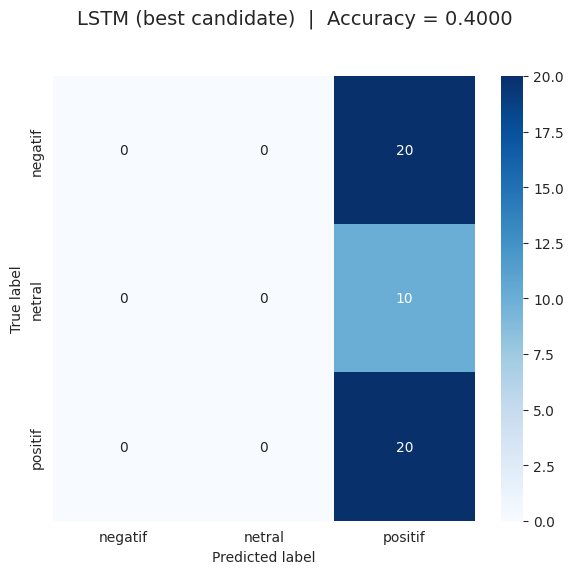

LSTM evaluation appended to results.


In [53]:
# Grid-search (small) for LSTM hyperparams
print("\n[9] Simple grid-search for LSTM hyperparams (small grid)")
best_lstm_val_loss = np.inf
best_lstm_info = None

for units in LSTM_GRID_UNITS:
    for epochs in LSTM_GRID_EPOCHS:
        print(f"\nTraining candidate LSTM: units={units}, epochs={epochs}, trainable_embedding={not FREEZE_EMBEDDING}")
        model = build_lstm_model(num_words=num_words,
                                 embed_size=EMBED_SIZE,
                                 embedding_matrix=embedding_matrix,
                                 max_seq_len=MAX_SEQ_LEN,
                                 num_classes=num_classes,
                                 lstm_units=units,
                                 bidirectional=False,
                                 trainable_embedding=not FREEZE_EMBEDDING)

        # checkpoints
        fname = os.path.join(OUT_DIR, f"lstm_units{units}_ep{epochs}.h5")
        cp = ModelCheckpoint(fname, monitor='val_loss', save_best_only=True, verbose=0)
        es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)

        history = model.fit(X_train_pad, y_train_keras,
                            epochs=epochs,
                            batch_size=BATCH_SIZE,
                            validation_split=VALIDATION_SPLIT,
                            callbacks=[cp, es],
                            verbose=1)

        # evaluate on validation (take last val_loss)
        val_loss = min(history.history.get('val_loss', [np.inf]))
        print(f"Candidate finished. Best val_loss={val_loss:.4f}")

        if val_loss < best_lstm_val_loss:
            best_lstm_val_loss = val_loss
            best_lstm_info = {"units": units, "epochs": epochs, "filepath": fname}
            # save best model path
            print(" --> New best LSTM candidate saved:", fname)

# Load best LSTM (if any)
if best_lstm_info is not None and os.path.exists(best_lstm_info['filepath']):
    best_lstm_fp = os.path.join(OUT_DIR, "best_lstm_final.h5")
    # copy or load and save under canonical name
    tf.keras.models.load_model(best_lstm_info['filepath']).save(best_lstm_fp)
    print("Best LSTM saved to:", best_lstm_fp)
    best_lstm_model = load_model(best_lstm_fp)
else:
    best_lstm_model = None
    best_lstm_fp = None

# Evaluate the best LSTM (if trained)
if best_lstm_model is not None:
    if num_classes == 2:
        pred_prob = best_lstm_model.predict(X_test_pad).ravel()
        pred = (pred_prob >= 0.5).astype(int)
    else:
        pred_prob = best_lstm_model.predict(X_test_pad)
        pred = np.argmax(pred_prob, axis=1)
    results.append(["LSTM(Embedding pretrained)"] + list(compute_metrics(y_test, pred)))
    plot_cm(y_test, pred, "LSTM (best candidate)")
    # save pointer
    print("LSTM evaluation appended to results.")
else:
    print("No LSTM model available to evaluate.")

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Klasifikasi Teks Menggunakan LSTM dan BiLSTM dengan Embedding


[10] Train BiLSTM using best LSTM units (if available)
Epoch 1/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.3799 - loss: 1.0937
Epoch 1: val_loss improved from inf to 1.11614, saving model to /content/klasifikasi_output_full_pipeline/bilstm_units128_ep4.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 587ms/step - accuracy: 0.3812 - loss: 1.0928 - val_accuracy: 0.3500 - val_loss: 1.1161
Epoch 2/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.4090 - loss: 1.0568
Epoch 2: val_loss did not improve from 1.11614
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.4093 - loss: 1.0567 - val_accuracy: 0.3500 - val_loss: 1.1569
Epoch 3/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4180 - loss: 1.0568
Epoch 3: val_loss did not improve from 1.11614
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.4186 - loss: 1.0575 - val_accuracy: 0.3500 - val_loss: 1.1685
Epoch 4/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4419 - loss: 1.0424
Epoch 4: val_loss did not improve from 1.11614
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.4455 - loss: 1.0427 - val_accuracy: 0.2500 - val_loss: 1.1517
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


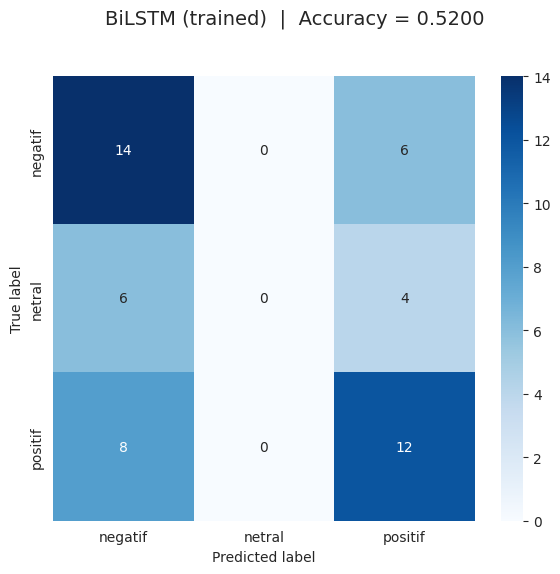

In [54]:
# Train a BiLSTM with the same best units (if we have best units)
print("\n[10] Train BiLSTM using best LSTM units (if available)")
best_units = best_lstm_info['units'] if best_lstm_info is not None else LSTM_GRID_UNITS[-1]
best_epochs = best_lstm_info['epochs'] if best_lstm_info is not None else LSTM_GRID_EPOCHS[-1]

bilstm_model = build_lstm_model(num_words=num_words,
                               embed_size=EMBED_SIZE,
                               embedding_matrix=embedding_matrix,
                               max_seq_len=MAX_SEQ_LEN,
                               num_classes=num_classes,
                               lstm_units=best_units,
                               bidirectional=True,
                               trainable_embedding=not FREEZE_EMBEDDING)

bilstm_fp = os.path.join(OUT_DIR, f"bilstm_units{best_units}_ep{best_epochs}.h5")
cp_bi = ModelCheckpoint(bilstm_fp, monitor='val_loss', save_best_only=True, verbose=1)
es_bi = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)

history_bi = bilstm_model.fit(X_train_pad, y_train_keras,
                              epochs=best_epochs,
                              batch_size=BATCH_SIZE,
                              validation_split=VALIDATION_SPLIT,
                              callbacks=[cp_bi, es_bi],
                              verbose=1)

if os.path.exists(bilstm_fp):
    bilstm_model = load_model(bilstm_fp)
    if num_classes == 2:
        pred_prob_bi = bilstm_model.predict(X_test_pad).ravel()
        pred_bi = (pred_prob_bi >= 0.5).astype(int)
    else:
        pred_prob_bi = bilstm_model.predict(X_test_pad)
        pred_bi = np.argmax(pred_prob_bi, axis=1)
    results.append(["BiLSTM(Embedding pretrained)"] + list(compute_metrics(y_test, pred_bi)))
    plot_cm(y_test, pred_bi, "BiLSTM (trained)")
else:
    print("BiLSTM checkpoint not found; skipping evaluation.")

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    plt.suptitle(f"{title}  |  Accuracy = {acc:.4f}", fontsize=14, y=0.95)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

In [55]:
print("\n===== HASIL PERCOBAAN KLASIFIKASI =====\n")
df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
print(df_results)

# Ranking berdasarkan F1
df_f1_rank = df_results.sort_values(by="F1", ascending=False).reset_index(drop=True)
print("\n===== RANKING MODEL BERDASARKAN F1 =====\n")
print(df_f1_rank)

# Ranking berdasarkan Accuracy
df_acc_rank = df_results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print("\n===== RANKING MODEL BERDASARKAN ACCURACY =====\n")
print(df_acc_rank)


===== HASIL PERCOBAAN KLASIFIKASI =====

                          Model  Accuracy  Precision    Recall        F1
0           BoW + MultinomialNB      0.72   0.706790  0.633333  0.622068
1            TF-IDF + LinearSVC      0.80   0.769444  0.733333  0.737879
2   TF-IDF + LogisticRegression      0.76   0.506410  0.633333  0.562582
3         TF-IDF + RandomForest      0.74   0.823300  0.633333  0.599534
4  Word2Vec(avg) + RandomForest      0.72   0.817460  0.616667  0.587029
5  FastText(avg) + RandomForest      0.58   0.512821  0.500000  0.481823
6     GloVe(avg) + RandomForest      0.68   0.733631  0.616667  0.621741
7    LSTM(Embedding pretrained)      0.40   0.133333  0.333333  0.190476
8  BiLSTM(Embedding pretrained)      0.52   0.348485  0.433333  0.384921

===== RANKING MODEL BERDASARKAN F1 =====

                          Model  Accuracy  Precision    Recall        F1
0            TF-IDF + LinearSVC      0.80   0.769444  0.733333  0.737879
1           BoW + MultinomialNB      0.

In [56]:
# ============================================================
# ===============  FINAL SUMMARY & ANALYSIS  =================
# ============================================================

print("\n========================================")
print("📊 FINAL SUMMARY & ANALYSIS")
print("========================================")

# Convert results → DataFrame
df_results = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1"]
)

# Ranking berdasarkan F1-score (paling umum untuk klasifikasi imbalance)
df_results_sorted = df_results.sort_values(by="F1", ascending=False).reset_index(drop=True)

print("\n=== 📌 Performance Table (Sorted by F1) ===")
display(df_results_sorted)


📊 FINAL SUMMARY & ANALYSIS

=== 📌 Performance Table (Sorted by F1) ===


,Model,Accuracy,Precision,Recall,F1
0,TF-IDF + LinearSVC,0.80,0.769444,0.733333,0.737879
1,BoW + MultinomialNB,0.72,0.706790,0.633333,0.622068
2,GloVe(avg) + RandomForest,0.68,0.733631,0.616667,0.621741
3,TF-IDF + RandomForest,0.74,0.823300,0.633333,0.599534
4,Word2Vec(avg) + RandomForest,0.72,0.817460,0.616667,0.587029
5,TF-IDF + LogisticRegression,0.76,0.506410,0.633333,0.562582
6,FastText(avg) + RandomForest,0.58,0.512821,0.500000,0.481823
7,BiLSTM(Embedding pretrained),0.52,0.348485,0.433333,0.384921
8,LSTM(Embedding pretrained),0.40,0.133333,0.333333,0.190476


In [57]:
# BEST MODEL DETECTOR
best_row = df_results_sorted.iloc[0]
best_model_name = best_row["Model"]

print("\n========================================")
print(f"🏆 BEST MODEL: {best_model_name}")
print("Accuracy   :", best_row['Accuracy'])
print("Precision  :", best_row['Precision'])
print("Recall     :", best_row['Recall'])
print("F1 Score   :", best_row['F1'])
print("========================================")


🏆 BEST MODEL: TF-IDF + LinearSVC
Accuracy   : 0.8
Precision  : 0.7694444444444444
Recall     : 0.7333333333333334
F1 Score   : 0.7378787878787879


## KESIMPULAN

* Model TF-IDF + LinearSVC terbukti menjadi model terbaik, karena memperoleh nilai Accuracy tertinggi sebesar 0.80 dan F1 Score tertinggi sebesar 0.7379 sehingga memberikan performa paling stabil dan seimbang.

* Model-model klasik berbasis TF-IDF dan BoW menunjukkan performa lebih baik dibandingkan model berbasis embedding dan deep learning, terutama karena dataset yang digunakan berukuran kecil.
* Model LSTM dan BiLSTM menunjukkan performa rendah, karena algoritma deep learning membutuhkan jumlah data yang jauh lebih besar agar dapat belajar pola secara efektif dan menghindari overfitting.
* TF-IDF terbukti menjadi representasi teks yang paling efektif pada dataset ini, karena mampu menangkap informasi kata yang relevan tanpa memerlukan jumlah data yang besar.
* Urutan performa model berdasarkan F1 Score menunjukkan bahwa metode klasik lebih unggul, di mana TF-IDF + LinearSVC berada di peringkat pertama, sementara LSTM berada di posisi terakhir.
* Model RandomForest dengan berbagai embedding (Word2Vec, GloVe, FastText) memberikan hasil yang cukup baik namun tetap tidak mampu menyaingi performa model SVM yang berbasis TF-IDF.
* Berdasarkan hasil keseluruhan, TF-IDF + LinearSVC direkomendasikan sebagai model final yang paling layak digunakan untuk proses klasifikasi pada penelitian ini.

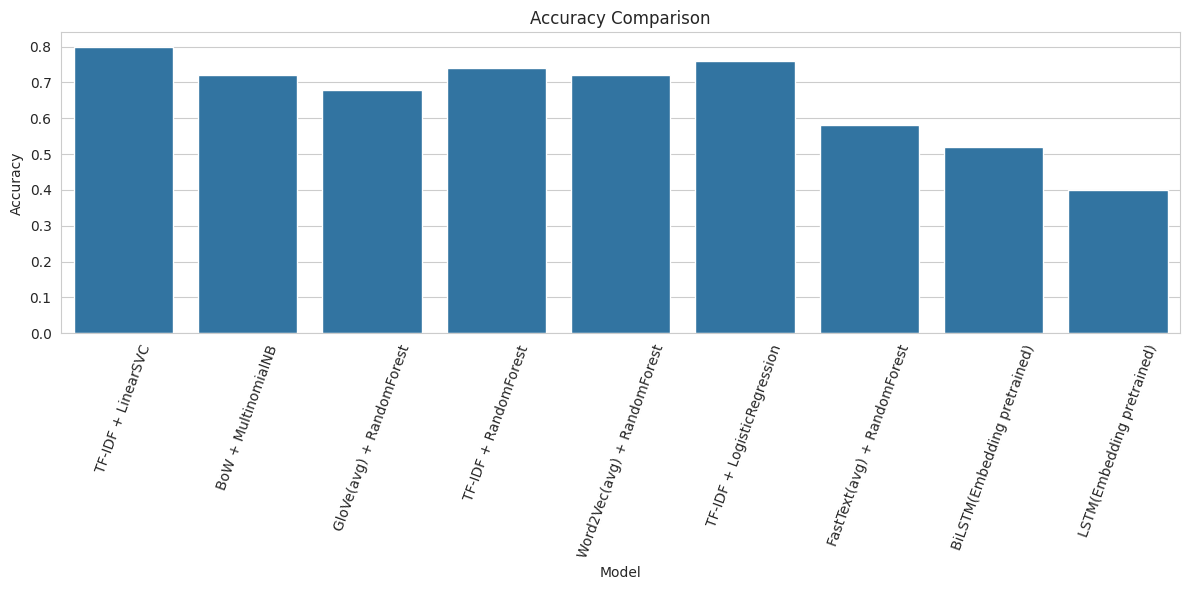

In [58]:
# PERFORMANCE BAR PLOTS
plt.figure(figsize=(12,6))
sns.barplot(data=df_results_sorted, x="Model", y="Accuracy")
plt.xticks(rotation=70)
plt.title("Accuracy Comparison")
plt.tight_layout()
plt.show()

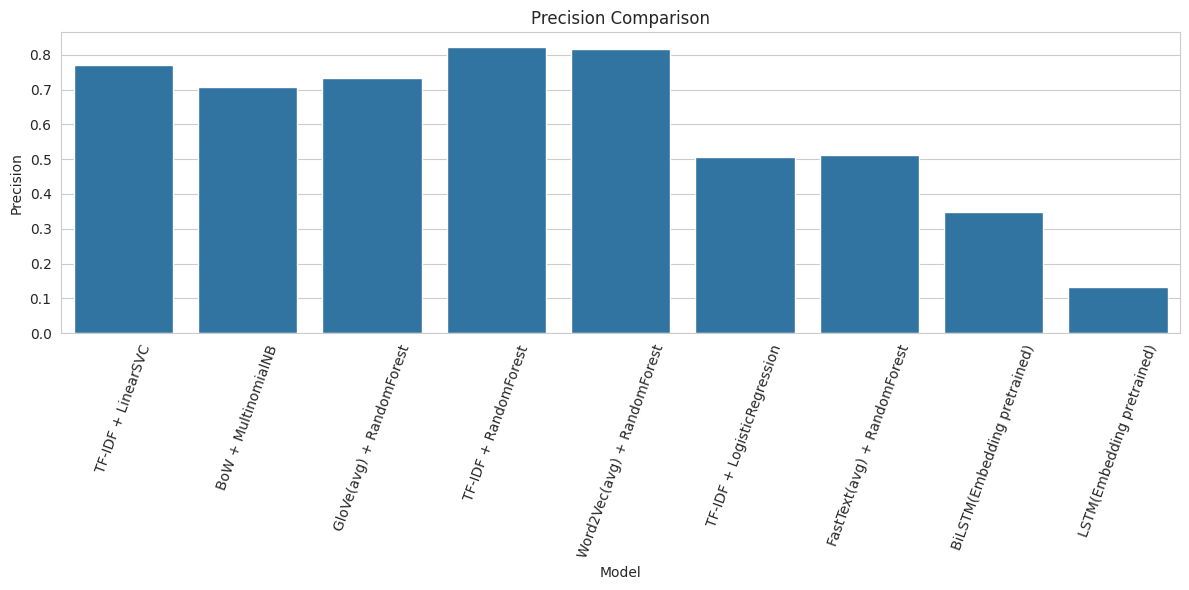

In [59]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_results_sorted, x="Model", y="Precision")
plt.xticks(rotation=70)
plt.title("Precision Comparison")
plt.tight_layout()
plt.show()

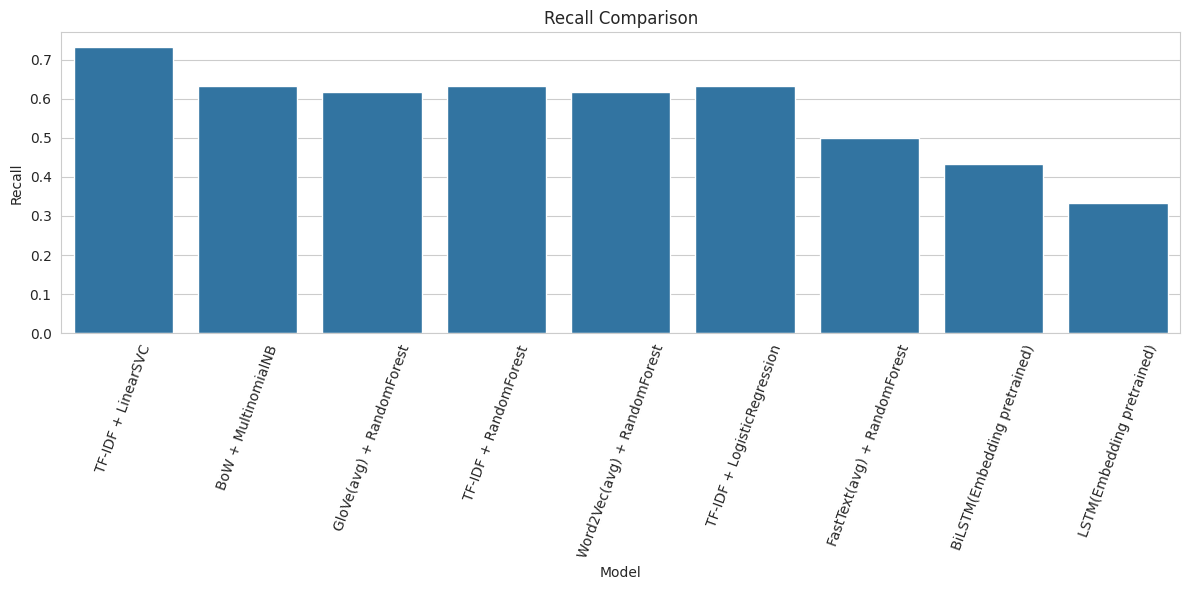

In [60]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_results_sorted, x="Model", y="Recall")
plt.xticks(rotation=70)
plt.title("Recall Comparison")
plt.tight_layout()
plt.show()

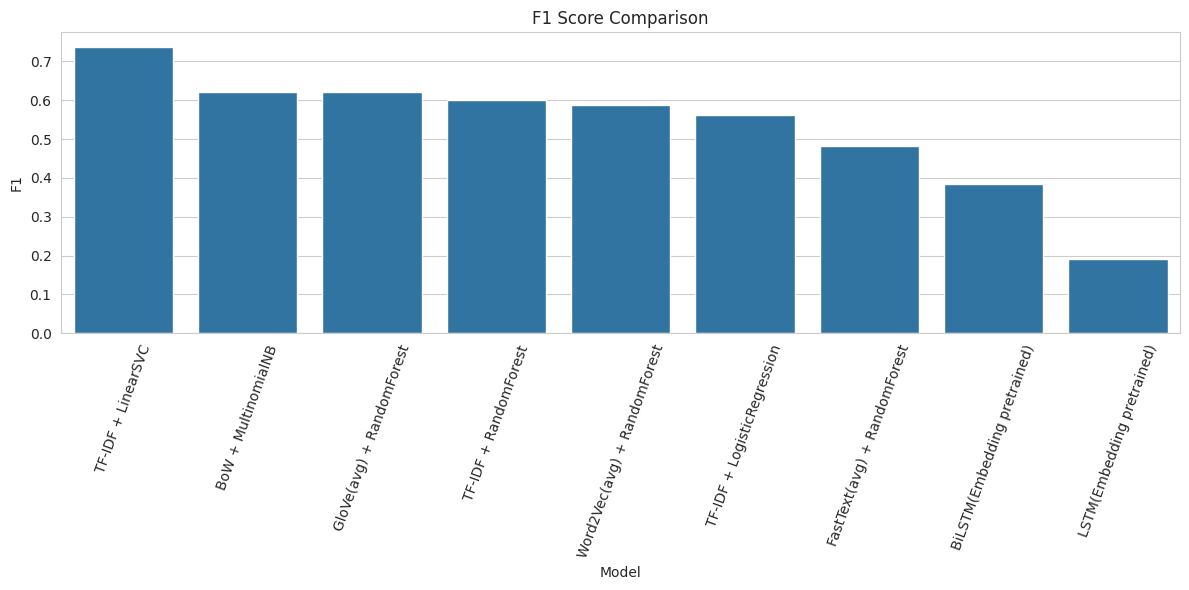

In [61]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_results_sorted, x="Model", y="F1")
plt.xticks(rotation=70)
plt.title("F1 Score Comparison")
plt.tight_layout()
plt.show()